## Background and Description

With the help of the stimulus checks, a low interest rate, and ample free time at home, retail investors shine like never before in 2021. The rise of “Robinhood Traders”, meme stocks, and r/WallStreetBets wrecked havoc on the market, most notoriously in GameStop (NYSE: GME) and AMC Entertainment (NYSE: AMC) in Janurary, pushing their prices up by over 700% in a week. Moreover, both stocks sustained their relatively high price without reverting to pre-hype prices. Thus, it becomes important to understand the behavior of retail investors and their impact on the stock to better control idiosyncratic risks for both institutions and individual investors.

This project intends to investigate one part of the relationship between retail investors and their impact on the stock market. Specifically, we want to find any relationship between posts on r/WallStreetBets, a notorious sub-Reddit credited for pushign the price of GameStop. Ultimately, we aim to determine the impact r/WallStreetBets has on individual stock prices and volume.

Various previous studies and project has investigated similar relationship between Reddit posts and market prices, but found middling results. Our project is novel in that 

1) it investigates the impact on a collection of individual stocks, generally smaller-cap stocks, instead of the overall market. Previous studies often use the Dow Jones index and S&P 500 as a proxy to study impact. These benchmarks are consisted of large cap companies with deep liquidility that are unlikely to be moved; 

2) we aim to use regression algorithms, instead of classificiation (often simply indicating up or down), to better quantify the relationship between Reddit posts and stocks;

3) we focus specifically on excess returns and excess volume, instead of the price or the direction of the price movement. This is both more percise, and more complementary to exisiting studies on the topic; 

4) unlike most public projects that focuses on using Reddit titles and assigning them equal weight, we use both comment titles and comments themselves, weighted by their upvotes. 


# Loading Packages

In [ ]:
!pip install afinn
!pip install pandasql
!pip install praw
!pip install psaw
!pip install yfinance
!pip install seaborn

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=a4ac1b1012bf9a8624b471d1d1bf7bb0ea73314917b0b211f87f85e43e3394d4
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn
  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=d84c72af7b290f0c23cf510d647c98882487765b7ad4332c0381853035934957
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql
     |████████████████████████████████| 163kB 17.8MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 6.3MB 19.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=583e0358d7b633bdc051d8b9e09a33b15f4cfa700f3c3e5ef5734293176080a0
  Stored in directory: /root/.cache/pip/wheels/f8/2a

In [ ]:
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sb
import sklearn
from afinn import Afinn
import re
import spacy
import glob
import csv
import yfinance as yf
import requests
from datetime import date, time, datetime
import math
import praw
from psaw import PushshiftAPI
import calendar
import time
import os
from google.colab import drive
import datetime as dt
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, utils, metrics, linear_model, metrics, svm, utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_array

# Web Crawling

## Scraping Data from Reddit (r/WallStreetBets)


To scrape data from the WallStreetBets subreddit, we use 2 separate APIs: PSAW and PRAW. PSAW allows us to collect historical data based on various filtering parameters with ease. This API has been particularly useful beacuse the number of submissions created over only 2 days of February can easily exceed 200,000. Pulling, filtering, processing, and sorting this data would easily take hours.

Scraping Reddit's data was far from easy due to poor documentation and uninformative silent failures when using the APIs. To pull data, we started with Reddit's web API. The Reddit API has a number of limitations such as only being able to pull at most 100 items from their databases per request and a limit on the rate at which you can make requests. This API was initially working well, but, the API had a limit on how far back into the past you could fetch data from. This limitation was extremely problematic since we were interested in historical data from WallStreetsBets. The most frustrating part of this limitation is that it is not documented anywhere so the obsol. To ensure that the problem was not due to our code pulling data faster than it's supposed to, I used the PRAW API which automatically handles and monitors the pull rate of requests. However, I unfortunately could not pull anymore data.

In order to circumvent this issue, I tried another API: PSAW. PSAW is a Python wrapper for another dataset/API called Pushshift. This API was recommended multiple times for pulling large amounts of historical data from users in the r/redditdev subreddit.

PSAW did allow me to pull tons of historical data and strangely enough provided me with approximately 10 times more submissions from the same time period pulled from PRAW. According to my understanding of how the Pushshift dataset, it pulls and saves posts as soon as they are posted and does not update them ever again. Thus, deleted submissions and comments that do not exist today would still appear in the Pushshift dataset. But, fortunately PSAW solves the historical data problem; however, of course, this dataset has an issue: the Pushshift API does not store the current number of up votes for a post since all data about a post is pulled at its creation. We require the correct number of up votes since that is one of our features we are using to predict financial data.

Now, I arrive at my final solution to scraping data: I pull the historical data from PSAW and use the unique identifiers that this dataset returns to access PRAW to obtain the current up votes for each submission/comment. These 2 dataframes are then merged to obtain the final historical dataset with up votes. In conclusion, by leveraging PRAW's current, up-to-date information with PSAW's historical identifying data I was able to generate the Reddit data we needed for our project.

In [ ]:
############################### SUBMISSIONS ####################################
def submissions_to_df(start_epoch, end_epoch, year, month, rand_idx):
  api = PushshiftAPI()

  # ~instantaneous
  start_time = time.time()
  # sample the database from a random 24-hour period within month
  a = np.random.randint(start_epoch, end_epoch, dtype=np.int64)
  b = int((dt.datetime.fromtimestamp(a) + dt.timedelta(hours=24)).timestamp())
  gen = api.search_submissions(before=b, after=a, subreddit='WallStreetBets', filter=['id', 'url','author', 'title', 'subreddit'], limit=100)

  # .d_ returns a description as a list of the ListGenerator object
  df = pd.DataFrame([obj.d_ for obj in gen])

  # Reddit object tags
  # t1 = comments
  # t2 = redditors
  # t3 = submissions
  # t4 = messages
  # t5 = subreddits
  # t6 = awards

  # though the dataset is extremely large, there is somehow a chance that no
  # submissions were made that day and will throw errors in the rest of the
  # function
  if len(df) == 0:
    return None

  df["id"] = df.apply(lambda row: "t3_" + row['id'], axis=1)
  df["date"] = df.apply(lambda row: dt.datetime.fromtimestamp(row['created_utc']).date(), axis=1)
  df["time"] = df.apply(lambda row: dt.datetime.fromtimestamp(row['created_utc']).time(), axis=1)
  df = df.set_index('id')
  df = df.sort_values(by='created_utc', axis=0, ascending=True)

  # store raw data in csv so that you wont have to pull anymore
  df.to_csv(str(month) + "_" + str(year) + "/" + str(rand_idx) + "/" + str(month) + "_" + str(year) +  "_submissions_no_ups_" + str(rand_idx) + ".csv")

  ############ getting upvotes of randomly sampled submissions ##################
  # setting check_for_async to false is necessary to avoid asynchronous errors
  r = praw.Reddit(
      client_id="cRal6KlDvG1YfA",
      client_secret="QgtnGq7l6VHoe-EpvFm9t8wbiDBvnw",
      user_agent="myBot",
      username="spencer_w-b",
      password="CIS545FinalProject",
      check_for_async=False
  )

  # Reddit.info documentation: https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html?highlight=info#praw.Reddit.info
  gen = r.info(fullnames=list(df.index))

  ups_list = [(item.name, item.ups) for item in gen]

  if len(ups_list) == 0:
    return None

  ########### zipping upvotes and subissions dataframe together #################
  # list of tuples to df
  # for some unknown reason data=ups_list doesnt work
  updf = pd.DataFrame.from_records(data=ups_list[:len(ups_list)-1], columns=['id', 'ups'])

  # megring the 2 dfs based on ids
  # the on parameter must be set otherwise it will think every row is different from the
  # other (ie the intersection is empty)
  submissions = pd.merge(df, updf, how='outer', on='id', indicator=True)
  submissions.rename(columns={'ups_y':'ups'}, inplace=True)
  submissions = submissions.set_index('id')

  submissions.to_csv(str(month) + "_" + str(year) + "/" + str(rand_idx) + "/" + str(month) + "_" + str(year) +  "_submissions_" + str(rand_idx) + ".csv")

  return submissions

comments_to_df() return a dataframe containing as many as 100 times the number of desired batches in a very similar fashion to submissions_to_df().

In [ ]:
################################## COMMENTS #####################################
# over only 2 days approximately 200k comments were posted to the wallstreetbets
# subreddit. this would be way too much data to handle over an entire month let alone
# an entire year. therefore i have decided to sample a small random subset of
# submission ids to pull comments from.
# to do this i will select a random 

def comments_to_df(start_epoch, end_epoch, year, month, rand_idx):
  api = PushshiftAPI()

  a = np.random.randint(start_epoch, end_epoch, dtype=np.int64)
  # i need to be carful of timedelta, though there is a lot of data the random time
  # range can somehow still fall in a moment when no comments were uploaded cauding
  # cdf to ultimately become empty and throw an error
  b = int((dt.datetime.fromtimestamp(a) + dt.timedelta(hours=24)).timestamp())
  gen = api.search_comments(before=b, after=a, subreddit='WallStreetBets', filter=['id', 'url','author', 'body', 'subreddit'], limit=100)

  cdf = pd.DataFrame([obj.d_ for obj in gen])

  if len(cdf) == 0:
    return None

  cdf["id"] = cdf.apply(lambda row: "t1_" + row['id'], axis=1)
  cdf["date"] = cdf.apply(lambda row: dt.datetime.fromtimestamp(row['created_utc']).date(), axis=1)
  cdf["time"] = cdf.apply(lambda row: dt.datetime.fromtimestamp(row['created_utc']).time(), axis=1)
  cdf = cdf.set_index('id')
  cdf = cdf.sort_values(by='created_utc', axis=0, ascending=False)

  ################################ getting ups ###################################
  # setting check_for_async to false is necessary to avoid asynchronous errors
  r = praw.Reddit(
      client_id="cRal6KlDvG1YfA",
      client_secret="QgtnGq7l6VHoe-EpvFm9t8wbiDBvnw",
      user_agent="myBot",
      username="spencer_w-b",
      password="CIS545FinalProject",
      check_for_async=False
  )

  # Reddit.info documentation: https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html?highlight=info#praw.Reddit.info
  gen = r.info(fullnames=list(cdf.index))

  # using star is the fastest way to preallocate a list
  ups_list = [-1] * cdf.shape[0]

  ups_list = [(item.name, item.ups) for item in gen]

  if len(ups_list) == 0:
    return None


  ################# zipping up ups_list and cdf into a single df #################
  # list of tuples to df
  # for some unknown reason data=ups_list doesnt work
  updf = pd.DataFrame.from_records(data=ups_list[:len(ups_list)-1], columns=['id', 'ups'])
  updf = updf.set_index('id')

  # the on parameter must be set otherwise it will think every row is different from the
  # other (ie the intersection is empty)
  comments = pd.merge(cdf, updf, how='outer', on='id', indicator=True)
  comments.pop('ups_x')
  comments.rename(columns={'ups_y':'ups'}, inplace=True)

  comments.to_csv(str(month) + "_" + str(year) + "/" + str(rand_idx) + "/" + str(month) + "_" + str(year) +  "_comments_" + str(rand_idx) + ".csv")

  return comments

In [ ]:
##################### MERGING COMMENTS AND SUBMISSIONS #########################
def merge_subs_coms(submissions, comments, year, month, rand_idx):
  # uncomment this if this is your first time running this notebook in a new session
  submissions.pop('_merge')
  comments.pop('_merge')

  data = pd.merge(submissions.reset_index(), comments.reset_index(), how='outer', on='id', indicator=True)
  data = submissions.reset_index().append(comments.reset_index())

  def to_text(id, title, body):
    if id[:2] == "t1":
      # comment
      return body
    else:
      # submission
      return title

  data['text'] = data.reset_index().apply(lambda row : to_text(row['id'], row['title'], row['body']), axis=1)
  data = data.drop(columns=['body', 'title'])

  data = data[data.text != '[removed]']
  data = data[data.text != '[deleted]']

  # remove if you want the integer indices to be duplicated/indices reset to zero 
  # when transitioning from submissions to comments
  data = data.reset_index(drop=True)

  top_data = data.sort_values(by='ups', axis=0, ascending=False)[:3000]

  # export the data
  data.to_csv(str(month) + "_" + str(year) + "/" + str(month) + "_" + str(year) +  "_data_" + str(rand_idx) + ".csv")
  top_data.to_csv(str(month) + "_" + str(year) + "/" + str(month) + "_" + str(year) +  "_top_data_" + str(rand_idx) + ".csv")

  return data, top_data

In [ ]:
# right now the batch size is set to 200
def month_data(month, year, batches):
  # make folder to store this month's data
  os.mkdir(str(month) + "_" + str(year))

  cal = {
      4 : (int(dt.datetime(2020, 4, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 4, 30, 23, 59, 59, 999999).timestamp())),
      5 : (int(dt.datetime(2020, 5, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 5, 31, 23, 59, 59, 999999).timestamp())),
      6 : (int(dt.datetime(2020, 6, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 6, 30, 23, 59, 59, 999999).timestamp())),
      7 : (int(dt.datetime(2020, 7, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 7, 31, 23, 59, 59, 999999).timestamp())),
      8 : (int(dt.datetime(2020, 8, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 8, 31, 23, 59, 59, 999999).timestamp())),
      9 : (int(dt.datetime(2020, 9, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 9, 30, 23, 59, 59, 999999).timestamp())),
      10 : (int(dt.datetime(2020, 10, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 10, 31, 23, 59, 59, 999999).timestamp())),
      11 : (int(dt.datetime(2020, 11, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 11, 30, 23, 59, 59, 999999).timestamp())),
      12 : (int(dt.datetime(2020, 12, 1, 0, 0, 0).timestamp()), int(dt.datetime(2020, 12, 31, 23, 59, 59, 999999).timestamp())),
      1 : (int(dt.datetime(2021, 1, 1, 0, 0, 0).timestamp()), int(dt.datetime(2021, 1, 31, 23, 59, 59, 999999).timestamp())),
      2 : (int(dt.datetime(2021, 2, 1, 0, 0, 0).timestamp()), int(dt.datetime(2021, 2, 28, 23, 59, 59, 999999).timestamp())),
      3 : (int(dt.datetime(2021, 3, 1, 0, 0, 0).timestamp()), int(dt.datetime(2021, 3, 31, 23, 59, 59, 999999).timestamp())),
  }

  start_epoch, end_epoch = cal[month]

  print(dt.datetime.fromtimestamp(start_epoch), dt.datetime.fromtimestamp(end_epoch))

  for b in np.arange(0,batches):#range(batches):
    print(b)
    os.mkdir(str(month) + "_" + str(year) + "/" + str(b))
    submissions = submissions_to_df(start_epoch, end_epoch, year, month, b)
    if submissions is None:
      continue
    comments = comments_to_df(start_epoch, end_epoch, year, month, b)
    if comments is None:
      continue
    merge_subs_coms(submissions, comments, year, month, b)
    print(submissions['date'].min(), submissions['date'].max())
    print(comments['date'].min(), comments['date'].max())

  batch_list = [None] * batches
  for b in range(batches):
    if os.path.isfile(str(month) + "_" + str(year) + "/" + str(month) + "_" + str(year) + "_data_" + str(b) + ".csv"):
      batch_list[b] = pd.read_csv(str(month) + "_" + str(year) + "/" + str(month) + "_" + str(year) + "_data_" + str(b) + ".csv")

  all_batched_data = pd.concat(batch_list, sort=False)
  all_batched_data = all_batched_data.drop(columns=['Unnamed: 0'])
  all_batched_data = all_batched_data.reset_index().drop_duplicates(subset=['id']).set_index('id')
  all_batched_data.to_csv(str(month) + "_" + str(year) + "/" + str(month) + "_" + str(year) +  "_all_batched_data" + ".csv")
  return all_batched_data

The following cell provides an example of how to call 1 month's worth of data. By calling month_data() with an integer representation of the month and year and the number of batches to pull from Reddit.

In [ ]:
# NOTE: month_data is hardcoded to only work for 3/2021 - 4/2020
month = 3
year 2021
# each batch contains ~50 comments and ~50 submissions pulled from a random 24
# hour time period of the specified month
batches = 400

start_time = time.time()
five_batches = month_data(2, 2021, 400)
end_time = time.time()
print("time to merge title and body cols: ", end_time - start_time, " seconds")
print("time to merge title and body cols: ", (end_time - start_time) / 60, " minutes")
print(five_batches.shape)
display(five_batches.head(10))

## Final Dataframe of Reddit Data
After downloading the data, we store it in a CSV file so that we don't have to run re-download it from the Reddit API each time, since there is a lot of data and it takes a very long time to download. Thus, we load the data from a few CSV files stored in Drive.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/My Drive/CIS 545 Final Project/3_2021/3_2021_data.csv' march_data.csv
!cp '/content/gdrive/My Drive/CIS 545 Final Project/2_2021_all_batched_data.csv' feb_data.csv
!cp '/content/gdrive/My Drive/CIS 545 Final Project/1_2021_all_batched_data.csv' jan_data.csv

In [ ]:
files = [i for i in glob.glob('/content/*.csv'.format('csv'))]
combined_df = pd.concat([pd.read_csv(f) for f in files])
combined_df.shape

(209113, 12)

# Evaluating Reddit Data

In this section, we are going to investigate the Reddit data that we've downloaded, getting it into a format on which we can run our model, and evaluating the text data on several different metrics. 

## Data Wrangling and Cleaning - Reddit Data

First, we will clean up the text data to make it easier to process. The biggest challenge here was determining which stocks, if any, a post or comment referred to, which is crucial in finding what, if any, relationship exists between the data and the stock value. As you'll see below, we experiment with several different methods to do this, and although there is no perfect solution, the one we stick with works fairly well. 

In order to make processing/evaluating the text easier and more uniform, we make everything lowercase and remove unnecessary text like multiple consecutive spaces and any special characters (i.e. @'s and $'s).

In [ ]:
title_df = combined_df[['text', 'ups', 'date']].copy().dropna()
title_df['text'] = title_df['text'].str.lower()
title_df['text'] = title_df['text'].apply(lambda x: re.sub('@[^\s]+','',x)) # remove @'s
title_df['text'] = title_df['text'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I)) #substitute multiple spaces with a single space
title_df['text'] = title_df['text'].apply(lambda x: ' '.join(re.findall(r'\w+', x))) # remove special characters
title_df['text'] = title_df['text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', x)) # remove single characters (assume no single character stocks referenced)
title_df.shape

(208011, 3)

###Assigning Stocks Symbols to Posts

As mentioned above, we try several different methods to determine which stocks are discussed in a particular post.

**Attempt #1**: Using the Spacy Package for Natural Language Processing

In [ ]:
title_df_2 = title_df.copy()

nlps = spacy.load('en')
title_df_2['# Organizations Mentioned'] = title_df_2['text'].apply(lambda x: len([s for s in nlps(x).ents if s.label_ == 'ORG']))
title_df_2['Organization Mentioned'] = title_df_2['text'].apply(lambda x: [s for s in nlps(x).ents if s.label_ == 'ORG'])

title_df_2['Cardinal Count'] = title_df_2['text'].apply(lambda x: len([s for s in nlps(x).ents if s.label_ == 'CARDINAL']))
title_df_2['Cardinal'] = title_df_2['text'].apply(lambda x: [s for s in nlps(x).ents if s.label_ == 'CARDINAL'])

title_df_2.head()

Unfortunately, this method didn't work very well, even on smaller datasets. The label_ feature corresponding to *ORG* or *CARDINAL* didn't line up with what we were looking for. We were fortunate to discover this early, however, since on larger datasets this method turned out to be extremly inefficient.

**Attempt #2**: Creating a Dictionary of Stock Symbols/Company Names

In this method, we download stock information from publicly available data, which we store in the form of CSV files in Drive. Then, we create a dictionary that maps both from a company's stock symbol to the symbol itself, and from their company name to the symbol itself. That way, we can call apply over the text column of the dataframe and check for the presence of the stock symbol or company name in the text. 

In [ ]:
!cp '/content/gdrive/My Drive/CIS 545 Final Project/nasdaq_screener.csv' screener_nasdaq.csv
!cp '/content/gdrive/My Drive/CIS 545 Final Project/nasdaq_screener_amex.csv' screener_amex.csv
!cp '/content/gdrive/My Drive/CIS 545 Final Project/nasdaq_screener_nyse.csv' screener_nyse.csv

In [ ]:
files = [i for i in glob.glob('/content/screener_*.csv'.format('csv'))]
stocks_df = {}
for infile in files:
  with open(infile, mode='r') as curr_file:
    reader = csv.reader(curr_file)
    symbol_to_symbol = {}
    name_to_symbol = {}
    for row in reader:
      symbol = row[0].lower()
      name = row[1].lower()
      symbol_to_symbol[symbol] = symbol
      name_to_symbol[name] = symbol
    cum_stocks = {**symbol_to_symbol, **name_to_symbol}
  stocks_df = {**stocks_df, **cum_stocks}
  
stocks_df.pop('symbol')
stocks_df.pop('name')

'symbol'

In [ ]:
title_df['Stock_Symbols'] = title_df['text'].apply(lambda x: [stocks_df[s] for s in x.split(' ') if s in stocks_df])
title_df.head(10)

,text,ups,date,Stock_Symbols
0,we have received over 50 emails about cciv and...,1.0,2021-01-12,"[cciv, on, it, cciv]"
1,yoloevery ev and fubo im retarted,1.0,2021-01-12,[fubo]
2,joining the gme gang,1.0,2021-01-12,[gme]
3,fellow autist spotted at panera,1.0,2021-01-12,[at]
4,hey bob can we usenew photo for todaypost for ...,1.0,2021-01-12,"[can, for, for, sna]"
5,my favourite cursed stock,1.0,2021-01-12,[]
6,amready for bigger bets,1.0,2021-01-12,[for]
7,recovering from tsla dip yesterday should ve l...,1.0,2021-01-12,"[tsla, one]"
8,not the biggest gains but still all thanks to ...,13.0,2021-01-12,"[all, be]"
9,my favourite cursed stock,1.0,2021-01-12,[]


Since our ultimate goal is to be able to group by the stock and date assigned to each post in order to compare to the closing price (and other metrics) of that stock over time, we need to only have one stock assigned to each row. Thus, we explode over the list of stock symbols assigned to each row, and then group by the stock.

Before we move on, however, we notice some flaws in this method and try to refine it. Notably, the way we call apply and search through the dictionary, we check for the presence of one word at a time as a key in the dictionary, so any keys that are more than one word (i.e. almost every company name) won't be detected. On top of that, many official company names, or at least the ones listed in the data we downloaded, include things like "Common Stock" or "Inc." at the end, which people would rarely refer to in a Reddit post. Additionally, there are a lot of stock symbols that are just common words or single letters, as you'll see below.

To handle this, we remove a handful of words which appear very frequently but are likely not referencing the actual stock. In addition, before we create our final dataset, we determine the number of appearances of each stock and sort them to find those which appear at the highest frequency. Then, using some visualization techniques and with some additional investigation, we find a reasonable cutoff for a top number of stocks to narrow down our search. Then, we create a new dictionary with only those stock symbols, and their company names shortened to their one-word, more colloquial names, and repeat the process above of calling apply and exploding on the stock symbols found.

In [ ]:
exploded_df = title_df.explode('Stock_Symbols')
group_query = """
SELECT Stock_Symbols AS stock, COUNT(*) AS count
FROM exploded_df
GROUP BY stock
ORDER BY count DESC
"""
exploded_df = ps.sqldf(group_query, locals()).dropna()
labels = ['for', 'on', 'it', 'are', 'all', 'at', 'be', 'can', 'new', 'one', 'so', 'dd',
          'out', 'now', 'go', 'an', 'a', 'or', 'by', 'has', 'next', 'good', 'see', 're',
          'any', 'big', 'love', 'post', 'best', 'he', 'else', 'vs', 'sos', 'ever',
          'well', 'real', 'free', 'low', 'fund', 'very', 'am', 'two', 'open', 'run',
          'tell', 'gain', 'move', 'huge', 'live', 'hope', 'nice', 'cash', 'man', 'ago'
          'stay', 'save', 'ship', 'fly', 'turn', 'fun', 'gold', 'true', 'job', 'link',
          'life', 'play', 'work', 'ride', 'bb', 'ago', 'app', 'car', 'cap', 'plan']
exploded_df = exploded_df[~exploded_df.stock.isin(labels)]
# gme, amc, pltr, rkt, amp, nok, tsla, sndl, nio, gt, uwmc, rh, coin, ll, cciv, rblx, tlry
exploded_df.head(30)

,stock,count
1,gme,30221
5,amc,9442
24,pltr,2590
26,rkt,2490
27,amp,2396
33,nok,1600
34,tsla,1592
38,sndl,1428
42,nio,1199
48,gt,980


### Visualizing Our Results - Most Frequently Mentioned Stocks

Here, we try to visualize our results using several easy methods.

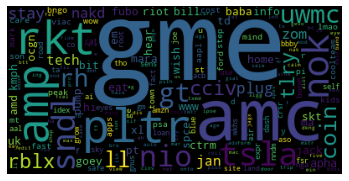

In [ ]:
wc = wordcloud.WordCloud()

word_dict = exploded_df.set_index('stock').T.to_dict('list')
for key, val in word_dict.items():
  word_dict[key] = val[0]

stock_wc = wc.fit_words(word_dict)
plt.imshow(stock_wc)
plt.axis('off')
plt.show()

This is a bit helpful, as can see some of the top stocks mentioned here. However, there remain several words that likely don't refer to stock symbols, like "jan" and "tech", despite us removing several and wordcloud's built in STOPWORDS list. Let's take a look at a graph of these values to try to determine if there's a reasonable cutoff, i.e. a stock we shouldn't investigate further because of a cutoff in its relative frequency.

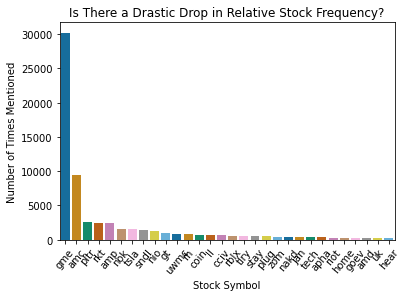

In [ ]:
sb_df = exploded_df.rename(columns={'stock':'Stock Symbol', 'count':'Number of Times Mentioned'})
ax = sb.barplot(x='Stock Symbol', y='Number of Times Mentioned', data=sb_df.iloc[:30], palette='colorblind')
ax.set_title('Is There a Drastic Drop in Relative Stock Frequency?')
fix_labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

As we see above, it's hard to tell where to cut it off because the data is so top-heavy. GME has over 30,000 mentions, and AMC over 9,000, whereas the rest all have around a couple thousand or less. Let's take a look again, this time ignoring some of the top stocks.

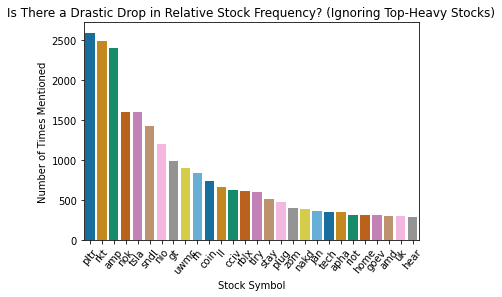

In [ ]:
ax = sb.barplot(x='Stock Symbol', y='Number of Times Mentioned', data=sb_df.iloc[2:30], palette='colorblind')
ax.set_title('Is There a Drastic Drop in Relative Stock Frequency? (Ignoring Top-Heavy Stocks)')
fix_labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

We can see it almost starts to flatten out around LL, until there's a minor drop after TLRY, where it drops below the ~600 mark, and a lot of words seem likely to just be everyday words. After investigating the top 17 stocks (up to TLRY), they all appear to be widely discussed on Reddit, and are thus, we believe, good to move forward with. So we set our cutoff as TLRY, and now we have our top 17 stocks.

In [ ]:
top_stocks = ['gme', 'amc', 'pltr', 'rkt', 'amp', 'nok', 'tsla', 'sndl', 'nio', 
              'gt', 'uwmc', 'rh', 'coin', 'll', 'cciv', 'rblx', 'tlry']
stocks_dict = {symbol: stocks_df[symbol] for symbol in top_stocks}

# GME - GameStop Corporation Common Stock
stocks_dict['gamestop'] = 'gme'

# AMC - AMC Entertainment Holdings Inc. Class A Common Stock

# PLTR - Palantir Technologies Inc. Class A Common Stock
stocks_dict['palantir'] = 'pltr'

# RKT - Rocket Companies Inc. Class A Common Stock
stocks_dict['rocket'] = 'rkt'

# AMP - Ameriprise Financial Inc. Common Stock
stocks_dict['ameriprise'] = 'amp'

# NOK - Nokia Corporation Sponsored American Depositary Shares
stocks_dict['nokia'] = 'nok'

# TSLA - Tesla Inc. Common Stock
stocks_dict['tesla'] = 'tsla'

# SNDL - Sundial Growers Inc. Common Shares
stocks_dict['sundial'] = 'sndl'

# NIO - NIO Inc. American depositary shares each  representing one Class A ordinary share

# GT - The Goodyear Tire & Rubber Company Common Stock
stocks_dict['goodyear'] = 'gt'

# UWMC - UWM Holdings Corporation Class A Common Stock
stocks_dict['uwm'] = 'uwmc'

# RH - RH Common Stock (Restoration Hardware Holdings)
stocks_dict['restoration'] = 'rh'

# COIN - Coinbase Global Inc. Class A Common Stock
stocks_dict['coinbase'] = 'coin'

# LL - Lumber Liquidators Holdings Inc Common Stock
stocks_dict['lumber'] = 'll'

# CCIV - Churchill Capital Corp IV Class A Common Stock
stocks_dict['churchill'] = 'cciv'

# RBLX - Roblox Corporation Class A Common Stock
stocks_dict['roblox'] = 'rblx'

# TLRY - Tilray Inc. Class 2 Common Stock
stocks_dict['tilray'] = 'tlry'

Now, we can once again assign stocks to specific posts, this time using our improved and narrowed-down dictionary. Let's take a look at how this affects the distribution of word frequencies as well, and how it compares to the old ones.

In [ ]:
title_df['Stock_Symbols'] = title_df['text'].apply(lambda x: [stocks_dict[s] for s in x.split(' ') if s in stocks_dict])

count_per_stock = title_df.explode('Stock_Symbols').dropna()
group_query = """
SELECT Stock_Symbols AS stock, COUNT(*) AS count
FROM count_per_stock
GROUP BY Stock
ORDER BY count DESC
"""
count_per_stock = ps.sqldf(group_query, locals()).dropna()
# count_per_stock

join_query = """
SELECT count_per_stock.stock as stock, count_per_stock.count as new_count, exploded_df.count as old_count
FROM count_per_stock
JOIN exploded_df
ON count_per_stock.stock = exploded_df.stock
"""
compare_df = ps.sqldf(join_query, locals())
compare_df

,stock,new_count,old_count
0,gme,33016,30221
1,amc,9442,9442
2,rkt,4076,2490
3,tsla,3264,1592
4,pltr,3185,2590
5,amp,2396,2396
6,nok,2088,1600
7,sndl,1646,1428
8,rblx,1396,603
9,nio,1199,1199


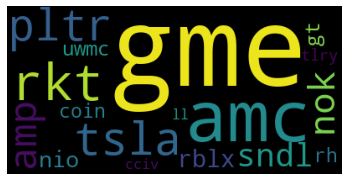

In [ ]:
wc = wordcloud.WordCloud()
word_dict = count_per_stock.set_index('stock').T.to_dict('list')
for key, val in word_dict.items():
  word_dict[key] = val[0]

stock_wc = wc.fit_words(word_dict)
plt.imshow(stock_wc)
plt.axis('off')
plt.show()

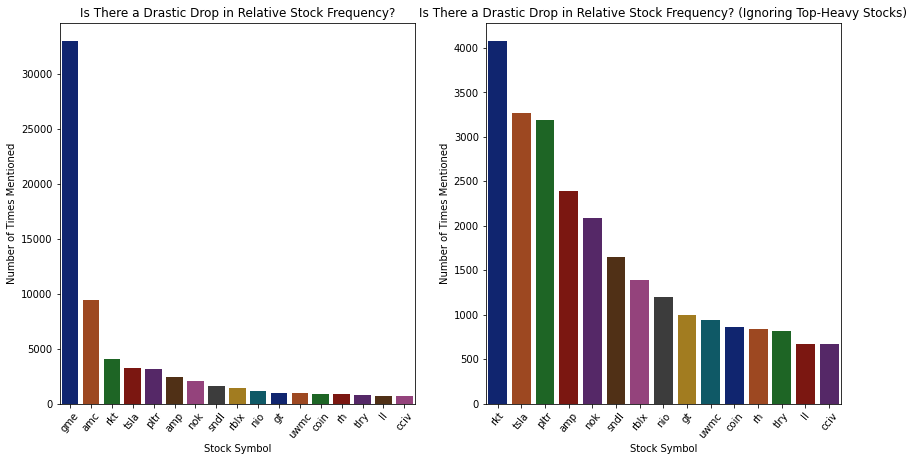

In [ ]:
sb_df = count_per_stock.rename(columns={'stock':'Stock Symbol', 'count':'Number of Times Mentioned'})

fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
ax1 = sb.barplot(x='Stock Symbol', y='Number of Times Mentioned', data=sb_df, palette='dark', ax=axs[0])
ax1.set_title('Is There a Drastic Drop in Relative Stock Frequency?')
fix_labels = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)

ax2 = sb.barplot(x='Stock Symbol', y='Number of Times Mentioned', data=sb_df.iloc[2:], palette='dark', ax=axs[1])
ax2.set_title('Is There a Drastic Drop in Relative Stock Frequency? (Ignoring Top-Heavy Stocks)')
fix_labels = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50)

While GME and AMC still mentioned way more than the rest, we were in fact able to find a lot more appearances for several stocks, and the rest of the stocks appears fairly balanced.

## Sentiment Analysis of Reddit Text

Now that we have our dictionary of top 15 stocks and more appropriate company names, we can finally obtain accurate evaluations of the text, corresponding to specific stocks. First, we assign stocks to posts using the method described above. Next, before we explode on the "Stock_Symbols" column, we determine several different scores on the text. We do this in order to avoid calculating scores on the same text multiple times, which may happen after exploding, which duplicates certain rows.

We evaluate the text on three metrics: 
1.   with the AFINN package
2.   Bull Score
3.   Bear Score

Bull Score and Bear Score relate to the commonly used terms in investing, bullish and bearish. Being bullish or a bull indicates that you believe the price of a stock will rise, and vice versa for bearish. These metrics make use of commonly used terms in r/WallStreetBets that indicate whether one thinks a stock's price will rise or fall, and assigns a score to a string based on how many of those words appear in the text.

In [ ]:
txt = "YOLO haha GME to the moon moon 🚀 all in yoloo going up up up 🚀 🚀 🚀"

bull_indicator = ["Call", "long", "going up", "rocket", "buy", "long term", "longterm", "bulls", "green", "moon", "YOLO", "all in", "up", "dd", "\U0001f680", "\U0001f315"]
bear_indicator = ["put", "short", "tits up", "drop", "bear", "sell", "leave", "red", "down"]

bull_indicator_re = '|'.join(bull_indicator) 
bear_indicator_re = '|'.join(bear_indicator)

bull_score = len(re.findall(bull_indicator_re, txt, re.I))
bear_score = len(re.findall(bear_indicator_re, txt, re.I))

print(bull_score, bear_score)

12 0


In [ ]:
afinn = Afinn(language='en')

title_df['Affin_Score'] = title_df['text'].apply(afinn.score)
title_df['Bull_Score'] = title_df['text'].apply(lambda x: len(re.findall(bull_indicator_re, x, re.I)))
title_df['Bear_Score'] = title_df['text'].apply(lambda x: len(re.findall(bear_indicator_re, x, re.I)))
exploded_df = title_df.explode('Stock_Symbols').dropna()
exploded_df.head()

,text,ups,date,Stock_Symbols,Affin_Score,Bull_Score,Bear_Score
0,we have received over 50 emails about cciv and...,1.0,2021-01-12,cciv,0.0,0,1
0,we have received over 50 emails about cciv and...,1.0,2021-01-12,cciv,0.0,0,1
2,joining the gme gang,1.0,2021-01-12,gme,0.0,0,0
7,recovering from tsla dip yesterday should ve l...,1.0,2021-01-12,tsla,0.0,0,0
17,buttplug rocket,1.0,2021-01-12,rkt,0.0,1,0


In [ ]:
group_query = """
SELECT Stock_Symbols AS Stock, date AS Date, SUM(ups * Affin_Score) as avg_affin, 
       SUM(ups * Bull_Score) as avg_bull, SUM(ups * Bear_Score) as avg_bear, 
       SUM(ups) as total_upvotes
FROM exploded_df
GROUP BY Stock, Date
"""
avged_df = ps.sqldf(group_query, locals()).dropna()
avged_df

,Stock,Date,avg_affin,avg_bull,avg_bear,total_upvotes
0,amc,2021-01-02,-26.0,121.0,1.0,219.0
1,amc,2021-01-03,49.0,56.0,11.0,87.0
2,amc,2021-01-04,-7.0,20.0,11.0,64.0
3,amc,2021-01-05,16.0,49.0,37.0,108.0
4,amc,2021-01-06,-33.0,23.0,7.0,45.0
...,...,...,...,...,...,...
1210,uwmc,2021-03-27,0.0,0.0,0.0,148.0
1211,uwmc,2021-03-28,23.0,0.0,0.0,24.0
1212,uwmc,2021-03-29,5.0,4.0,2.0,237.0
1213,uwmc,2021-03-30,31.0,492.0,233.0,397.0


### Visualizing Our Results - Sentiment Analysis

Now, let's take a look at what these scores look like for our stocks over time, taking a look at our two most common stocks: GME and AMC.

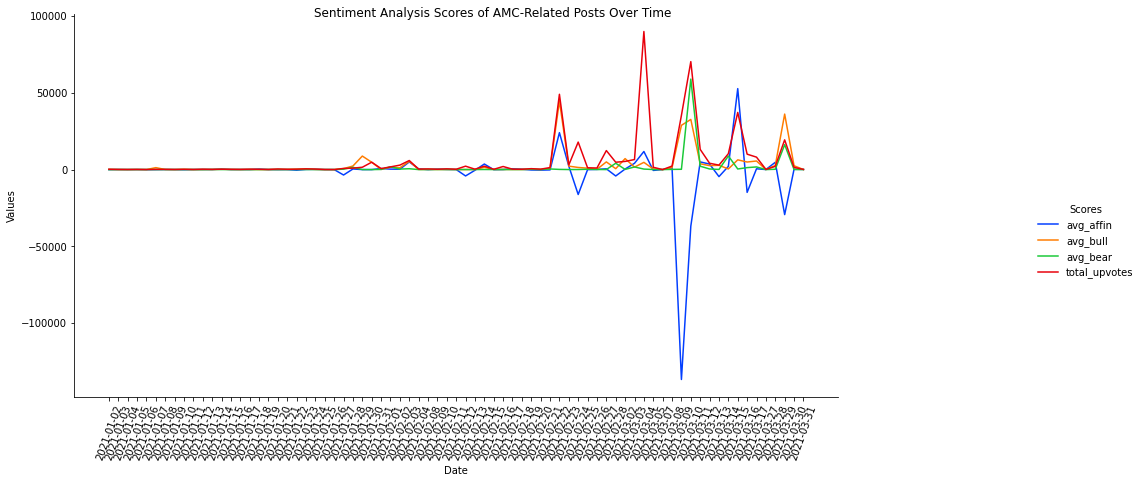

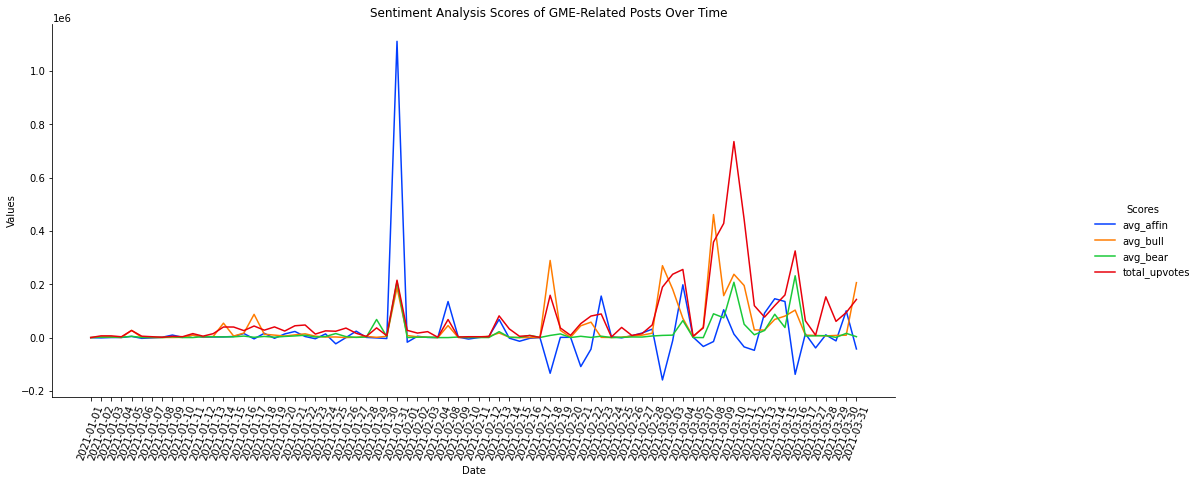

In [ ]:
# AMC & GME over time
amc_df = avged_df[avged_df.Stock == 'amc'].drop(labels=['Stock'], axis=1)
amc_df = amc_df.melt('Date', var_name='Scores', value_name='Values')
g = sb.relplot(x='Date', y='Values', hue='Scores', data=amc_df, kind='line', palette='bright')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Sentiment Analysis Scores of AMC-Related Posts Over Time')
fix_labels = g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=70)

gme_df = avged_df[avged_df.Stock == 'gme'].drop(labels=['Stock'], axis=1)
gme_df = gme_df.melt('Date', var_name='Scores', value_name='Values')
g = sb.relplot(x='Date', y='Values', hue='Scores', data=gme_df, kind='line', palette='bright')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Sentiment Analysis Scores of GME-Related Posts Over Time')
fix_labels = g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=70)

# amc_gme_df = avged_df[avged_df.Stock == 'amc'].append(avged_df[avged_df.Stock == 'gme'], ignore_index=True)
# melted_df = amc_gme_df.melt(id_vars=['Date', 'Stock'], 
#                             value_vars=['avg_affin', 'avg_bull', 'avg_bear', 'total_upvotes'],
#                             var_name='Scores', value_name='Values')
# g = sb.relplot(x='Date', y='Values', data=melted_df, hue='Scores', col='Stock', height=6, kind='line', palette='bright')

We can see that often Afinn score is inversely related to bear score, but this relationship doesn't always hold, and in some cases when Afinn is low or negative, bear score is high. It could've been helpful to use other, perhaps more accurate metrics or ways to evaluate the text, including more natural language processing techniques. 

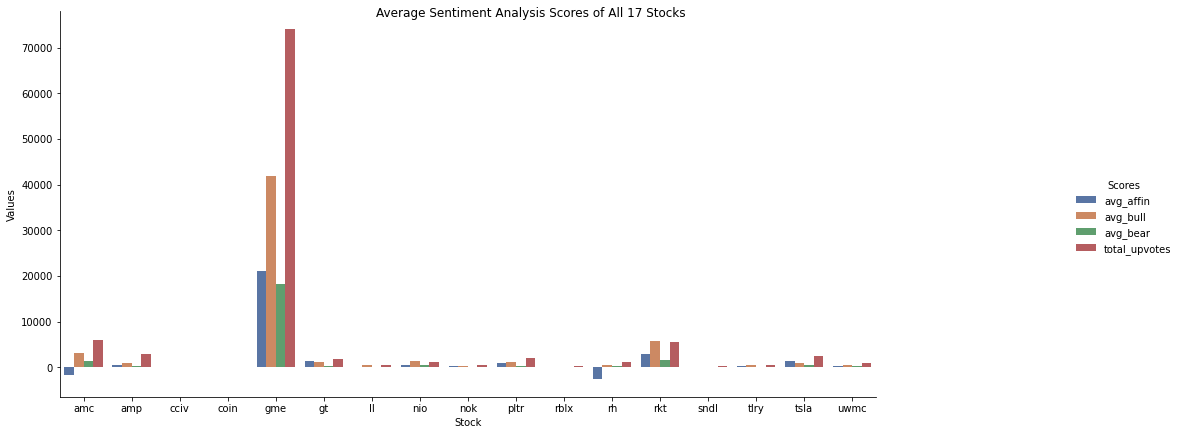

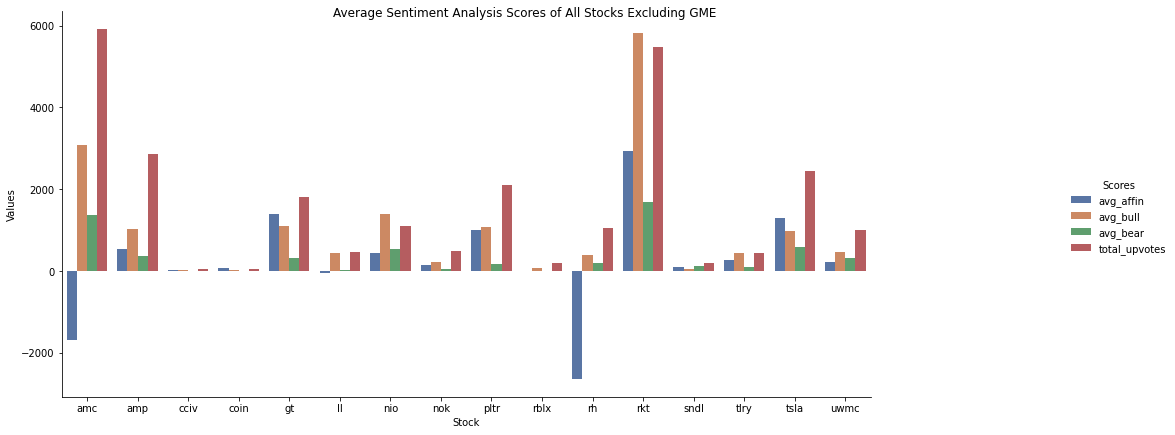

In [ ]:
# Aggregate Scores for All Stocks in Bar Graph
aggr_df = avged_df.drop(labels=['Date'], axis=1).groupby(by='Stock').agg({'avg_affin':'mean',
                                                                          'avg_bull':'mean',
                                                                          'avg_bear':'mean',
                                                                          'total_upvotes':'mean'})
melted_aggr = aggr_df.reset_index().melt('Stock', var_name='Scores', value_name='Values')
g = sb.catplot(x='Stock', y='Values', hue='Scores', data=melted_aggr, kind='bar', palette='deep')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Average Sentiment Analysis Scores of All 17 Stocks')

melted_aggr = aggr_df.drop(labels='gme').reset_index().melt('Stock', var_name='Scores', value_name='Values')
g = sb.catplot(x='Stock', y='Values', hue='Scores', data=melted_aggr, kind='bar', palette='deep')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Average Sentiment Analysis Scores of All Stocks Excluding GME')

# Obtaining Stock Information from Yahoo! Finance


To obtain financial data, we use data from Yahoo! Finance. Since Yahoo! no longer provides a free API, we use the yfinance package that is standard in the finance industry.

Since we focus on individual stocks, to guage what impact, if at all, Reddit comment has on them, we want to measure the "excess" returns and volumn caused by the posts, compared to a benchmark.

For excess returns, we use the S&P 500 index ("SPY") as a proxy for the whole stock market, which acts as the benchmark. We then calcualte the "expected returns" by multiplying individual stock beta*, a measure of individual stock volatility compared to the whole market, to the SPY return of the day. Excess returns will be the actual stock returns of the day minus the expected returns.

*An additional note on beta calculation: since the yfinance package calculates beta with 5-year monthly data, it does not return a beta for newer stocks. Since newer stocks are quite overrepresented (over 50%) of our target, we assign the beta to be the average beta in our dataset (1.5).

For excess volume, we choose the previous rolling one-week (5 trading days, not including the day itself to preserve objectivity) average volume as the benchmark to avoid any weekday effects, which is industry standard to measure short-term volume. Excess volume is the percertage of which the actual daily volume differs from the rolling average.

In [ ]:
spy = yf.Ticker("SPY")
hist_spy = spy.history(period = "3mo")

df_spy = hist_spy.drop(columns =["Open", 'High', 'Low', "Dividends", "Stock Splits"])
df_spy['Daily Returns'] = df_spy['Close'].pct_change()

# Financial data needed for stocks: gme, amc, pltr, rkt, amp, nok, tsla, sndl, nio, gt, uwmc, rh, coin, ll, cciv, rblx, tlry

stock_list= [s.upper() for s in top_stocks]

financial_data_df = pd.DataFrame(columns=['Stock', 'Date', 'Excess_Returns', 'Excess_Vol'])

for stock in stock_list:
  df = yf.Ticker(stock).history(period = "3mo")
  df = df.drop(columns =["Open", 'High', 'Low', "Dividends", "Stock Splits"])

  df['Stock'] = stock.lower()
  df['Daily Returns'] = df['Close'].pct_change()

  beta = yf.Ticker(stock).info["beta"]
  if beta is None:
    beta = 1.5 
  df['Expected Returns'] = df_spy['Daily Returns']*beta

  df['Excess_Returns'] = df['Daily Returns'] - df['Expected Returns']
  
  df['Avg Vol Prev Wk'] = df['Volume'].rolling(5).mean().shift(1)
  df['Excess_Vol'] = (df['Volume'] - df['Avg Vol Prev Wk'])/df['Avg Vol Prev Wk']

  df = df.reset_index()
  df = df[['Stock', 'Date', 'Excess_Returns', 'Excess_Vol']]
  financial_data_df = financial_data_df.append(df, ignore_index=True)

financial_data_df

,Stock,Date,Excess_Returns,Excess_Vol
0,gme,2021-02-08,NaN,NaN
1,gme,2021-02-09,-0.162710,NaN
2,gme,2021-02-10,0.016899,NaN
3,gme,2021-02-11,0.000981,NaN
4,gme,2021-02-12,0.034415,NaN
...,...,...,...,...
966,tlry,2021-04-29,-0.051375,0.661760
967,tlry,2021-04-30,0.000591,0.087711
968,tlry,2021-05-03,-0.077624,0.310081
969,tlry,2021-05-04,-0.037892,0.128451


One issue we encountered obtaining the financial data is how new some of our feature stocks are. For example, RKT or Rocket Companies, IPOed in late 2020, and half of our list are traded less than 2 years on the market. This creates an issue as some financial data, like beta, are either calculated in a long period of time, and could be unstable for new stocks. In the future, we could do our own reggressions on a weekly/daily basis to obtain some missing beta values. 

# Combining the Data into One Dataframe

Now that we have data from both Reddit and Yahoo! Finance, ordered by date and stock symbols, we can combine them into one dataframe to use for classification.

Here, we also want to touch on why we selected these features, specifically avg_affin, avg_bull, avg_bear, and total_upvotes, but not others.

Avg_affin: it measures the average sentiment score of a specific stock on that specific date, weighted by number of upvotes. It is included as the baseline sentiment analysis from Reddit posts. 

Avg_bull and avg_bear: we realize Reddit, like many other online forums, have lingos and expressions not captured by the generalized sentiment analysis. Additionally, many words have specific meaning in markets and finance. Thus, we developed our own list aiming to caputre these sentiment. Due to the time constriant and the ad hoc nature of looking for these words, the list is very limited, but we aim to expand the list in the future.  

Total_upvotes: it indicates general popularity of the post. 

Features not included are previous closing price, opening price, and other financial data. We often see these features in other price prediction models. However, since we are only aiming to find the impact of Reddit rather than coming up with the ultimate trading algorithm, we ignore these features. 

In [ ]:
# rename datasets such that date and stock have the same name
avged_df['Date'] = pd.to_datetime(avged_df['Date'])

merged_data = pd.merge(financial_data_df, avged_df, how='inner', on=['Date', 'Stock'], indicator=False).dropna()
merged_data

,Stock,Date,Excess_Returns,Excess_Vol,avg_affin,avg_bull,avg_bear,total_upvotes
5,gme,2021-02-16,-0.056726,-0.649489,-2672.0,236.0,8454.0,7538.0
6,gme,2021-02-17,-0.071690,-0.536503,278.0,128.0,425.0,646.0
7,gme,2021-02-18,-0.122012,0.472777,-133916.0,289546.0,8120.0,158936.0
8,gme,2021-02-19,-0.005666,0.074781,862.0,27306.0,13833.0,36185.0
9,gme,2021-02-22,0.119309,0.376320,-43361.0,57983.0,648.0,80915.0
...,...,...,...,...,...,...,...,...
434,tlry,2021-03-16,-0.111563,0.261237,2.0,118.0,111.0,136.0
435,tlry,2021-03-17,0.009606,-0.463272,3.0,11.0,7.0,17.0
436,tlry,2021-03-29,-0.019057,-0.381543,89.0,156.0,0.0,134.0
437,tlry,2021-03-30,0.025905,-0.391922,32.0,158.0,1.0,99.0


## Visualization

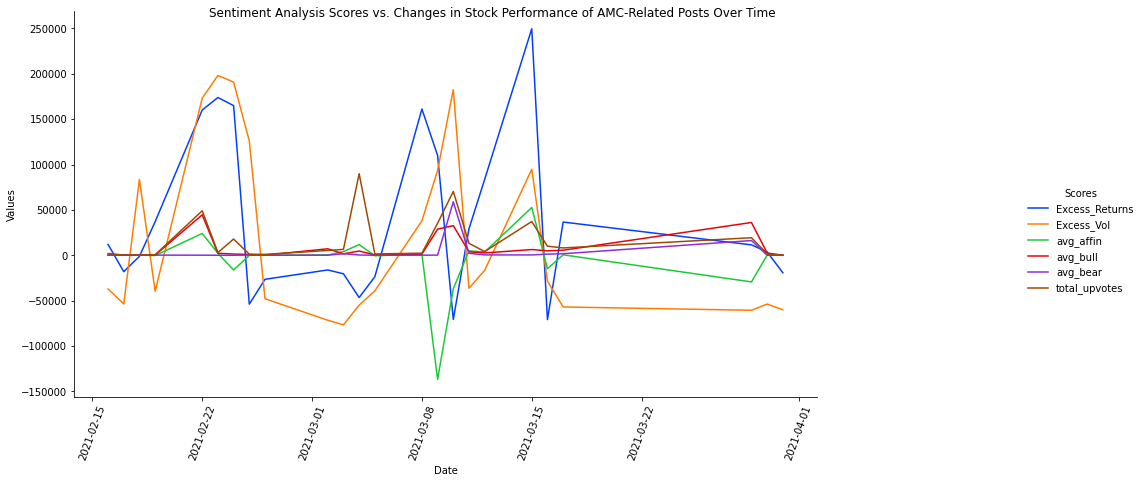

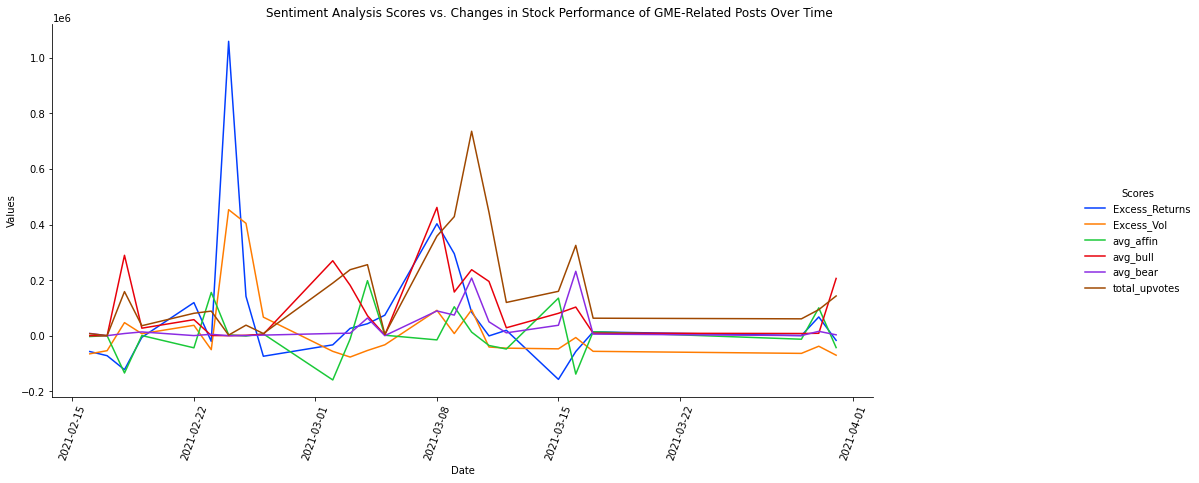

In [ ]:
amc_df = merged_data[merged_data.Stock == 'amc'].drop(labels=['Stock'], axis=1)
amc_df['Excess_Returns'] = amc_df['Excess_Returns'] * 1000000
amc_df['Excess_Vol'] = amc_df['Excess_Vol'] * 100000
amc_df = amc_df.melt('Date', var_name='Scores', value_name='Values')
g = sb.relplot(x='Date', y='Values', hue='Scores', data=amc_df, kind='line', palette='bright')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Sentiment Analysis Scores vs. Changes in Stock Performance of AMC-Related Posts Over Time')
fix_labels = g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=70)

gme_df = merged_data[merged_data.Stock == 'gme'].drop(labels=['Stock'], axis=1)
gme_df['Excess_Returns'] = gme_df['Excess_Returns'] * 1000000
gme_df['Excess_Vol'] = gme_df['Excess_Vol'] * 100000
gme_df = gme_df.melt('Date', var_name='Scores', value_name='Values')
g = sb.relplot(x='Date', y='Values', hue='Scores', data=gme_df, kind='line', palette='bright')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Sentiment Analysis Scores vs. Changes in Stock Performance of GME-Related Posts Over Time')
fix_labels = g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=70)

From the visualizations of the individual stock prices and their sentiment scores, we find Reddit generally act as a lagging indicator of the price movement. That is, they act more reactionary than predictive to excess returns and excess volume. 

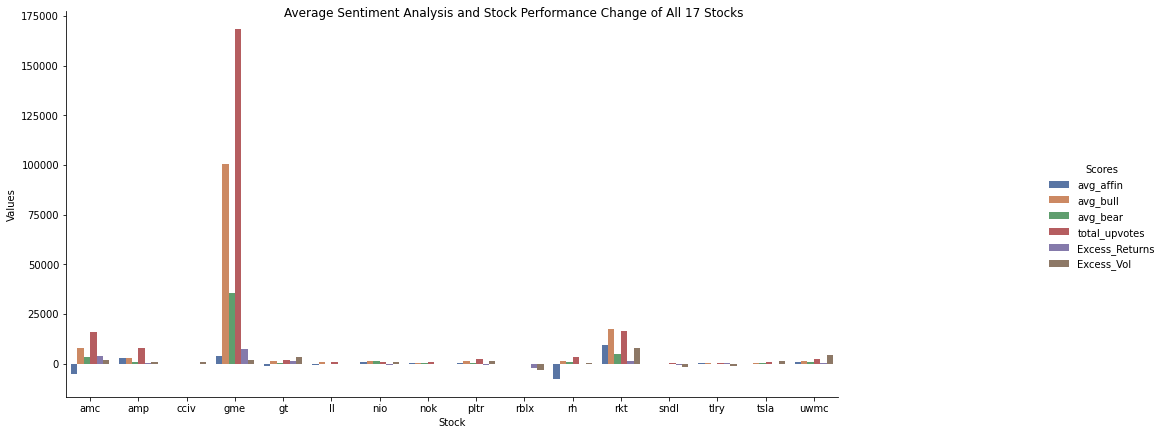

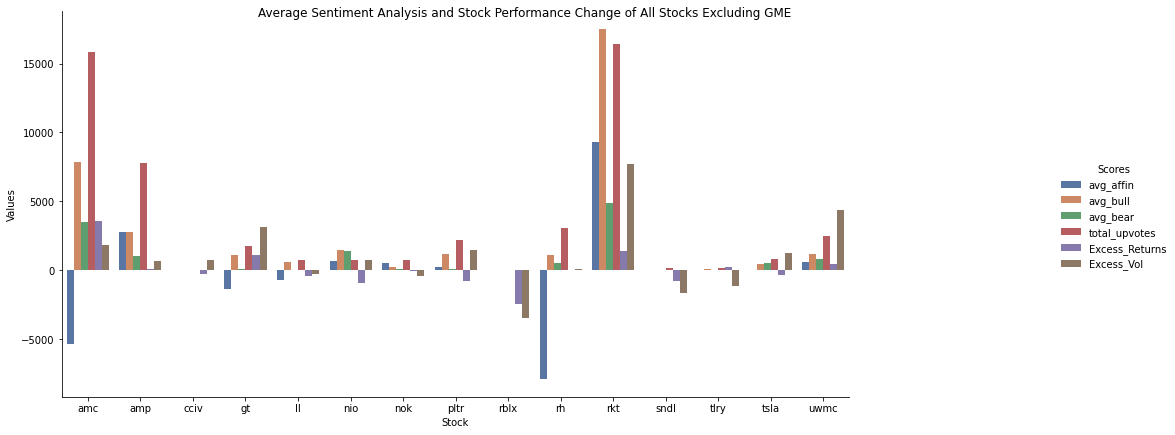

In [ ]:
# Aggregate Scores for All Stocks in Bar Graph
aggr_df = merged_data.drop(labels=['Date'], axis=1).groupby(by='Stock').agg({'avg_affin':'mean',
                                                                             'avg_bull':'mean',
                                                                             'avg_bear':'mean',
                                                                             'total_upvotes':'mean',
                                                                             'Excess_Returns': 'mean',
                                                                             'Excess_Vol': 'mean'})
aggr_df['Excess_Returns'] = aggr_df['Excess_Returns'] * 100000
aggr_df['Excess_Vol'] = aggr_df['Excess_Vol'] * 10000
melted_aggr = aggr_df.reset_index().melt('Stock', var_name='Scores', value_name='Values')
g = sb.catplot(x='Stock', y='Values', hue='Scores', data=melted_aggr, kind='bar', palette='deep')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Average Sentiment Analysis and Stock Performance Change of All 17 Stocks')

melted_aggr = aggr_df.drop(labels='gme').reset_index().melt('Stock', var_name='Scores', value_name='Values')
g = sb.catplot(x='Stock', y='Values', hue='Scores', data=melted_aggr, kind='bar', palette='deep')
size = g.fig.set_size_inches(18, 6)
title = g.fig.suptitle('Average Sentiment Analysis and Stock Performance Change of All Stocks Excluding GME')

# Creating Classifier
Due to the novel nature of the project, there are few current literature on the proper model to use. Thus we try using a variety of regression models, with GridSearch, and assess their effectiveness with R-Squared, RMSE, and MAPE, three popular measures of model sucess in financial literature, compared to the volatiliy of the stocks themselves. 

In [ ]:
# LOGISTIC REGRESSION

x = merged_data.drop(columns = ['Excess_Returns', 'Excess_Vol', 'Stock'])
x['Date'] = x['Date'].map(dt.datetime.toordinal)
y1 = merged_data.Excess_Returns
y2 = merged_data.Excess_Vol

x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size = 0.33, random_state = 8)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

lab_enc = preprocessing.LabelEncoder()
encoded_y1_train = lab_enc.fit_transform(y1_train)
encoded_y1_test = lab_enc.fit_transform(y1_test)
encoded_y2 = lab_enc.fit_transform(y2)

logisticRegr1 = LogisticRegression()
logisticRegr1.fit(x_train, encoded_y1_train)
y1_pred = logisticRegr1.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y1_test, y1_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y1_test, y1_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

correlation_matrix = np.corrcoef(y1_test, y1_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print('R-Squared :', r_squared)

In [ ]:
merged_data['Date'] = pd.to_datetime(merged_data.Date, format = '%Y-%m-%d')
merged_data.index = merged_data['Date']

x = merged_data.drop(columns = ['Excess_Returns', 'Excess_Vol', 'Stock', 'Date'])
y1 = merged_data.Excess_Returns
y2 = merged_data.Excess_Vol


x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size = 0.33, random_state = 9)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

classifiers = [
               svm.SVR(),
               linear_model.SGDRegressor(),
               linear_model.LassoLars(),
               linear_model.ARDRegression(),
               linear_model.PassiveAggressiveRegressor(),
               linear_model.TheilSenRegressor(),
               linear_model.LinearRegression()
]

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


for item in classifiers:
  print(item)
  clf = item
  clf.fit(x_train, y2_train)
  pred = clf.predict(x_test)
  correlation_matrix = np.corrcoef(y2_test, pred)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2

  print ('Variance of Volume is :', statistics.variance(y2_test))
  print ('Standard Deviation of Volume is :', np.sqrt(statistics.variance(y2_test)))
  print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, pred))
  print('MAPE:', MAPE(y2_test, pred), "%")
  print('Mean Squared Error:', metrics.mean_squared_error(y2_test, pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, pred)))
  print('R-Squared:', r_squared)
  print('---')

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean Absolute Error: 0.062384894844669615
Mean Squared Error: 0.0088441020500265
Root Mean Squared Error: 0.09404308613623066
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Mean Absolute Error: 0.05465281976717362
Mean Squared Error: 0.007713545387201863
Root Mean Squared Error: 0.08782679196692694
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)
Mean

After testing multiple random states and checking different measures, we find the ARD Regression to be the most stable and effective model, consistently outperforming the benchmark. As a result, we further investigate the model in a later section. 

In [ ]:
x = merged_data.drop(columns = ['Excess_Returns', 'Excess_Vol', 'Stock'])
x['Date'] = x['Date'].map(dt.datetime.toordinal)
y1 = merged_data.Excess_Returns
y2 = merged_data.Excess_Vol

merged_data['Date'] = pd.to_datetime(merged_data.Date, format = '%Y-%m-%d')
merged_data.index = merged_data['Date']

x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size = 0.33, random_state = 7)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size = 0.33, random_state = 7)

param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 10, 15, 20, 25, 30, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [5, 10, 25, 40]
}

rf1 = RandomForestRegressor()
grid_search1 = GridSearchCV(estimator = rf1, param_grid = param_grid, cv = 10)
grid_search1.fit(x_train, y1_train)
best_grid1 = grid_search1.best_params_

rf2 = RandomForestRegressor()
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid, cv = 10)
grid_search2.fit(x_train, y2_train)
best_grid2 = grid_search2.best_params_


y1_pred = grid_search1.predict(x_test)
y2_pred = grid_search2.predict(x_test)

print ('Variance of Excess Return is :', statistics.variance(y1_test))
print ('Standard Deviation of Excess Return is :', np.sqrt(statistics.variance(y1_test)))

print('---')

print(best_grid1)

print('Mean Absolute Error:', metrics.mean_absolute_error(y1_test, y1_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y1_test, y1_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

print('---')

print ('Variance of Excess Volume is :', statistics.variance(y2_test))
print ('Standard Deviation of Excess Volume is :', np.sqrt(statistics.variance(y2_test)))

print(best_grid2)

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

Variance of Excess Return is : 0.007299731486601189
Standard Deviation of Excess Return is : 0.08543846608291367
{'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 5, 'n_estimators': 25}
Mean Absolute Error: 0.053567919893391956
Mean Squared Error: 0.007307674984516554
Root Mean Squared Error: 0.08548494010360277
Variance of Excess Volume is : 0.4631126943785152
Standard Deviation of Excess Volume is : 0.6805238382147353
---
{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 5, 'n_estimators': 5}
Mean Absolute Error: 0.5242518736259776
Mean Squared Error: 0.5433676357250046
Root Mean Squared Error: 0.7371347473325379


In [ ]:
################## tuning ARDRegressor hyperparameters ########################
x = merged_data.drop(columns = ['Excess_Returns', 'Excess_Vol', 'Stock'])
x['Date'] = x['Date'].map(dt.datetime.toordinal)
y1 = merged_data.Excess_Returns
y2 = merged_data.Excess_Vol

merged_data['Date'] = pd.to_datetime(merged_data.Date, format = '%Y-%m-%d')
merged_data.index = merged_data['Date']

x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size = 0.33, random_state = 7)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size = 0.33, random_state = 7)

param_grid = {
    'n_iter': [150, 300, 450, 500],
    'copy_X': [True],
    'alpha_1': [1e-6, 1e-7, 1e-8],
    'alpha_2': [1e-6, 1e-7, 1e-8],
    'lambda_1': [1e-6, 1e-7, 1e-8],
    'lambda_2': [1e-6, 1e-7, 1e-8]
}

ard1 = linear_model.ARDRegression()
grid_search1 = GridSearchCV(estimator = ard1, param_grid = param_grid, cv = 10)
grid_search1.fit(x_train, y1_train)
best_grid1 = grid_search1.best_params_
#grid1_accuracy = evaluate(best_grid1, x_test, y1_test)

ard2 = linear_model.ARDRegression()
grid_search2 = GridSearchCV(estimator = ard2, param_grid = param_grid, cv = 10)
grid_search2.fit(x_train, y2_train)
best_grid2 = grid_search2.best_params_


y1_pred = grid_search1.predict(x_test)
y2_pred = grid_search2.predict(x_test)

print ('Variance of Excess Return is :', statistics.variance(y1_test))
print ('Standard Deviation of Excess Return is :', np.sqrt(statistics.variance(y1_test)))

print('---')

print(best_grid1)

print('Mean Absolute Error:', metrics.mean_absolute_error(y1_test, y1_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y1_test, y1_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

print('---')

print ('Variance of Excess Volume is :', statistics.variance(y2_test))
print ('Standard Deviation of Excess Volume is :', np.sqrt(statistics.variance(y2_test)))

print(best_grid2)

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

Variance of Excess Return is : 0.008580923613895189
Standard Deviation of Excess Return is : 0.09263327487407097
---
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'copy_X': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 150}
Mean Absolute Error: 0.04894767881592621
Mean Squared Error: 0.008544800301051545
Root Mean Squared Error: 0.09243808901665776
---
Variance of Excess Volume is : 2.234102256341049
Standard Deviation of Excess Volume is : 1.494691358221171
{'alpha_1': 1e-08, 'alpha_2': 1e-06, 'copy_X': True, 'lambda_1': 1e-06, 'lambda_2': 1e-08, 'n_iter': 150}
Mean Absolute Error: 0.5642764709983759
Mean Squared Error: 2.2153415064900748
Root Mean Squared Error: 1.4884023335409262


However, after using GridSearch, we did not find significant improvements on its performance. It speaks to how difficult it is to predict stock prices using historical data. It could also result from the extensive list of stocks and dates we included in the dataset. 

Below we also tried random forest model. Compared to other models, it does not excel in any of the measures. 

In [ ]:
import statistics


merged_data['Date'] = pd.to_datetime(merged_data.Date, format = '%Y-%m-%d')
merged_data.index = merged_data['Date']

x_gme = merged_data.loc[merged_data['Stock'] == 'gme']


x = x_gme.drop(columns = ['Excess_Returns', 'Excess_Vol', 'Stock', 'Date'])
y1_gme = x_gme.Excess_Returns
y2_gme = x_gme.Excess_Vol


x_train, x_test, y1_gme_train, y1_gme_test = train_test_split(x, y1_gme, test_size = 0.33, random_state = 8)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

classifiers = [
               svm.SVR(),
               linear_model.SGDRegressor(),
               linear_model.LassoLars(),
               linear_model.ARDRegression(),
               linear_model.PassiveAggressiveRegressor(),
               linear_model.TheilSenRegressor(),
               linear_model.LinearRegression()
]

from sklearn import metrics
from sklearn.utils import check_array

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


for item in classifiers:
  print(item)
  clf = item
  clf.fit(x_train, y1_gme_train)
  pred = clf.predict(x_test)
  correlation_matrix = np.corrcoef(y1_gme_test, pred)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2

  print ('Variance of Excess Return is :', statistics.variance(y1_gme_test))
  print ('Standard Deviation of Excess Return is :', np.sqrt(statistics.variance(y1_gme_test)))
  print('Mean Absolute Error:', metrics.mean_absolute_error(y1_gme_test, pred))
  print('MAPE:', MAPE(y1_gme_test, pred), "%")
  print('Mean Squared Error:', metrics.mean_squared_error(y1_gme_test, pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_gme_test, pred)))
  print('R-Squared:', r_squared)
  print('---')

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Variance of Excess Return is : 0.12857689951950116
Standard Deviation of Excess Return is : 0.3585762115917635
Mean Absolute Error: 0.2113312559215415
MAPE: 226.967838837874 %
Mean Squared Error: 0.14717990419913443
Root Mean Squared Error: 0.3836403318202277
R-Squared: 0.01646404588249268
---
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Variance of Excess Return is : 0.12857689951950116
Standard Deviation of Excess Return is : 0.3585762115917635
Mean Absolute Error: 0.21675999424763817
MAPE: 

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Variance of Excess Return is : 0.12857689951950116
Standard Deviation of Excess Return is : 0.3585762115917635
Mean Absolute Error: 0.20287096218517536
MAPE: 333.0608444291832 %
Mean Squared Error: 0.15434954889844416
Root Mean Squared Error: 0.39287345150626324
R-Squared: 0.03841112589395872
---
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Variance of Excess Return is : 0.12857689951950116
Standard Deviation of Excess Return is : 0.3585762115917635
Mean Absolute Error: 0.23170699903535813
MAPE: 1255.587208487077 %
Mean Squared Error: 0.17182417819080353
Root Mean Squared Error: 0.4145168008546862
R-Squared: 0.02155648901370129
---


# Conclusion
Unsurprisingly, project found a weak predictive relationship between the Reddit r/WallStBets posts and individual stock performances. This is due to the highly unpredictable nature ("a random walk") of stock prices in general. Furthmore, Reddit seem more reactionary rather than predictive of stock performances. For specific high profile stocks like GME and AMC, the impact of Reddit might be more pronounced; however, as we include a list of stock, the relationship does not seem to generalize well. 

In the future, it would be helpful to have more data to train and test our models on. Unfortunately, we were limited by the time we had and ability to download data from Reddit, which takes a very long time, and after all of our manipulation, 200k+ rows turned into less than 400.

We also would’ve liked to include more features, like perhaps some Natural Language Processing to better evaluate the text data. In addition, we understand that our method of assigning stocks to posts is still not perfect, and we would have hoped to come up with a more effective solution.

We also could try to get data from more sources, since this is just one subreddit and we could definitely expand the scope of the project into not only more subreddits, but also into other sources like news articles and major events, that certainly affect stock volume and growth.

In order to improve the accuracy of our models we would like to test out different machine learning models as well. One class of models we could use include neural networks. Due to the neural network’s ability to approximate highly nonlinear functions, this may be a good fit for our data, but overfitting would be a serious concern since financial data tends to be chaotic. We would also like to explore predicting finer time series information since we are looking at reddit and financial data spanning an entire day. Exploring the data at an hourly rate could be more interesting for understanding on a small time scale.

Lastly, it would be fun to look at cryptocurrencies, since they are more heavily in retail investors and are thus more manipulatable.